In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

<h3>Forward Problem - Generating Training Data</h3>

In [2]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:] that could be
    # strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

In [3]:
# set number of Fourier basis 
nfb = 128

# set radius of spatial domain
radius = 16

# create vector of real space points for plotting
nx = 1024
xvec = np.linspace(-radius, radius, nx)

# construct matrix to convert Fourier basis coefficients 
# into real space values
nvec = np.arange(-nfb, nfb+1) # nvec=-nfb,...,0,...,nfb
convmat = np.exp(1j * np.pi * np.outer(nvec, xvec) / radius) / np.sqrt(2 * radius)

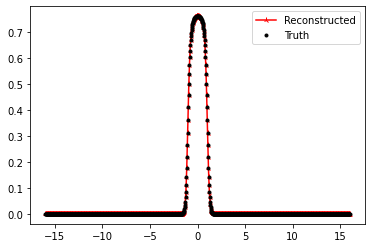

Relative norm difference: 5.0204902261950173e-05


In [4]:
# this code transforms the initial state psi0 to the Fourier basis
# the resulting vector is called inita

psi0choice = 0
def gen_inita():
    def psi0(x, choice=0):
        if choice == 0:
            # rounded box function
            return 1.0 + np.tanh((1 - x**2)/0.5)
        elif choice == 1:
            # triangular pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
        elif choice == 2:
            # parabolic pulse
            return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
        elif choice == 3:
            # hyperbolic secant squared
            return (np.cosh(x))**(-2)
        elif choice == 4:
            # Laplace
            return np.exp(-np.abs(x))
        else:
            print('Initial State Function: Did not recognise your choice.')
            return None

    # normalize psi0
    norm = np.sqrt(si.quad(lambda x: np.abs(psi0(x))**2, a=-radius, b=radius)[0])
    def normpsi0(x):
        return psi0(x)/norm

    # transform psi0 to Fourier basis using quadrature method
    # i.e., compute the Fourier coefficients by integration
    vraw = np.zeros(nfb+1, dtype=np.complex128)
    for thisn in range(nfb+1):
        def integ(x):
            return (2 * radius) ** (-0.5) * np.exp(-1j * np.pi * thisn * x / radius) * normpsi0(x)
        def rinteg(x):
            return np.real(integ(x))
        def iinteg(x):
            return np.imag(integ(x))
        vraw[thisn] = si.quad(rinteg, a=-radius, b=radius)[0] + 1j * si.quad(iinteg, a=-radius, b=radius)[0]

    return np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw]), normpsi0(xvec)

inita, normpsi0true = gen_inita()

# check if the reconstructed psi0 is "close enough" to the true psi0
psi0recon = inita @ convmat
plt.plot(xvec, psi0recon.real, color='red', marker='2', linestyle='-', label="Reconstructed")
plt.plot(xvec, normpsi0true.real, color='black', marker='.', linestyle='', label="Truth")
plt.legend()
plt.show()

# quantify difference between reconstructed psi0 and true psi0 
print('Relative norm difference:', nl.norm(normpsi0true - psi0recon) / nl.norm(normpsi0true))

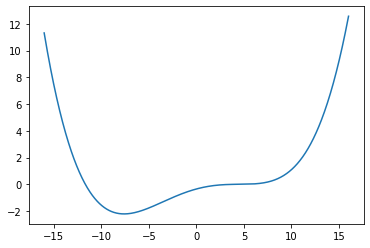

In [5]:
# define potential for generating training data

def v(x, choice=0):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # rescaled symmetric double well potential
        return 0.0025*(x**2 - 25)**2
    elif choice == 2:
        # scaled asymmetric double well potential
        return 0.0003*((x-3)**4 + 10*(x-5)**3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x**2 + 0.25)
    else:
        print('Potential Function: Choice not recognised.')
        return None

# compute true potential
vchoice = 2
vtrue = v(xvec, choice=vchoice)

# plot true potential
plt.plot(xvec, vtrue)
plt.show()

(16, 16)
(1024, 16)


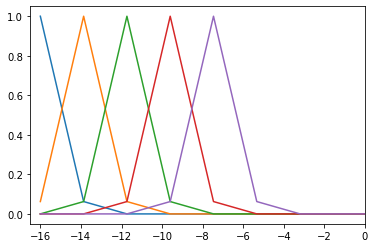

In [6]:
# set number of Gaussian basis
ng = 16

# vector of Gaussian basis centers in real space
xg, dg = np.linspace(-radius, radius, ng, retstep=True)

# alpha determines the amount of overlap of our basis
# it shouldn't be too much or too little, it should also
# scale with the number of basis used.
# here alpha is computed by setting the full width half max
# equal to the spacing between Gaussian centers
alpha = 4 * np.log(2) / dg**2

# this forms the Gaussian basis matrix (used to convert real space
# functions to the Gaussian basis)
gmat = np.exp(-alpha * (xg[:,np.newaxis] - xg)**2)
print(gmat.shape)

# this forms the matrix used for converting Gaussian basis coefficients
# to real space values (used for plotting)
gmatplot = np.exp(-alpha * (xvec[:,np.newaxis] - xg)**2)
print(gmatplot.shape)

# show first 5 basis to check overlap
for i in range(5):
    plt.plot(xg, np.exp(-alpha * (xg - xg[i])**2))
plt.xlim((-radius - 0.5, 0))
plt.show()

(16,)


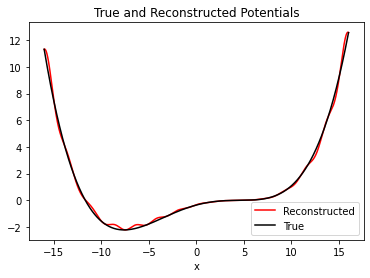

Relative Norm Difference: 0.05827189845309226


In [7]:
# this code computes the Gaussian basis coefficients
# of the true potential

# We use gmat here because numpy.linalg.inv() requires
# the input matrix be square
cfftrue = nl.inv(gmat) @ v(xg, choice=vchoice)
print(cfftrue.shape)

# reconstruct the potential from the Gaussian basis coefficents
vtruerecon = gmatplot @ cfftrue

# plot real potential vs. reconstructed potential
plt.plot(xvec, vtruerecon, 'r', label='Reconstructed')
plt.plot(xvec, vtrue, 'k', label='True')
plt.title('True and Reconstructed Potentials')
plt.xlabel('x')
plt.legend()
plt.show()

print('Relative Norm Difference:', nl.norm(vtruerecon - vtrue) / nl.norm(vtrue))

In [8]:
# this code computes the potential matrix and its
# gradient in the Fourier basis given a set of Gaussian
# basis coefficients.
# cff is the vector of Gaussian basis coefficients

k = np.pi * np.arange(0, 2*nfb+1) / radius
expmat = np.exp((-k**2 / (4*alpha))[:, np.newaxis] + (-1j*k[:,np.newaxis]*xg))
gvmatcnst = (1 / (2 * radius)) * np.sqrt(np.pi / alpha) * expmat

gradgvmat = np.zeros((ng, 2*nfb+1, 2*nfb+1), dtype=np.complex128)
for i in range(ng):
    gradgvmat[i,:]=toeplitz(gvmatcnst.T[i].conj(), gvmatcnst.T[i])
print(gradgvmat.shape)

@njit
def gvmat(cff):
    column = gvmatcnst @ cff.astype(np.complex128)
    row = column.conj()
    return toeplitz(r=row, c=column)

(16, 257, 257)


---
**Functions for Propagating System Given Some amat**

In [9]:
# forward propagation
# this code constructions the Hamiltonian matrix
# and performs an eigendecomposition to create 
# the forward propagation matrix, it then propagates
# the given inita nt times steps foward in time

# number of elements for toeplitz representation
m = 2*nfb + 1

# set the time step size for propagating
dt = 0.01

# set the number of steps to propagate "a" vector in time
nt = 200

# construct kinetic matrix
# this is constant for a given system
kmat = np.diag(np.arange(-nfb,nfb+1) ** 2 * np.pi ** 2 / (2 * radius ** 2))

@njit
def propa(cff, initacff):
    # from the potential matrix (in the Fourier basis)
    # using a set of Gaussian basis coefficients
    vmatcff = gvmat(cff)

    # construct Hamiltonian matrix (in Fourier basis)
    hmatcff = kmat + vmatcff

    # diagonalize the Hamiltonian matrix (eigendecomposition)
    speccff, statescff = np.linalg.eigh(hmatcff)
    
    # form the propagator matrices
    propamat = statescff @ np.diag(np.exp(-1j*speccff*dt)) @ np.conj(statescff.T)
    proplammat = statescff @ np.diag(np.exp(1j*speccff*dt)) @ np.conj(statescff.T)
    
    # propagate the a vector, i.e., solve the *forward* problem
    amatcff = np.zeros((nt+1, 2*nfb+1), dtype=np.complex128)
    amatcff[0,:] = np.copy(initacff)
    for j in range(nt):
        amatcff[j+1,:] = propamat @ amatcff[j,:]
    
    return speccff, statescff, amatcff, proplammat

In [10]:
# this code propagates the lambda vector backward in time,
# i.e., solve the *adjoint* problem

@njit
def proplam(amatcff, thisamattrue, proplammat):
    lambmat = np.zeros((nt+1, 2*nfb+1), dtype=np.complex128)
    lambmat[nt,:] = amatcff[nt,:] - thisamattrue[nt, :]
    for j in range(nt-1,0,-1):
        lambmat[j,:] = amatcff[j,:] - thisamattrue[j, :] + proplammat @ lambmat[j + 1, :]
    
    return lambmat

---
**Compute True amat**

In [11]:
# this code propagates inita using hmattrue produce amattrue

spectrue, statestrue, amattrue, _ = propa(cfftrue, inita)

# transform amat to real space
psimattrue = amattrue @ convmat

# check if psimattrue is normalized for every time step
print(np.sqrt(np.sum(np.abs(amattrue) ** 2, axis=1)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<h3>Inverse Problem</h3>

**Code for Adjoint Method**

In [12]:
# this code computes the Lagrangian the input cff here
# is the vector of modeling parameters

laghistlen = 50
laghist = np.zeros(laghistlen)
itercnt = 0

def justlag(cffprdt):
    global laghist, itercnt
    global glbspecprdt, glbstatesprdt, glbamatprdt, glblambmat
    
    # propagate inita with cffprdt
    glbspecprdt, glbstatesprdt, glbamatprdt, proplammat = propa(cffprdt, inita)
    
    # propagate lambmat with glbamatprdt
    glblambmat = proplam(glbamatprdt, amattrue, proplammat)
    
    # compute Lagrangian
    resid = glbamatprdt - amattrue
    lag = 0.5*np.real(np.sum(np.conj(resid)*resid))
    itercnt += 1

    # roll the history back one and replace with newest value
    # i.e. put the newest value on the end of the stack
    laghist = np.roll(laghist, -1)
    laghist[-1] = lag
    
    # print the latest values of the Lagrangian
    print(f'{itercnt} Lagrangan={laghist[-1]}', end='\x1b[2K\r')
    return lag
    

In [13]:
# compute the gradients
# the input x is the vector of modeling parameters (theta or thetahat)

@njit
def gradhelp(specprdt, statesprdt):
    alldmat = np.zeros((ng, m, m), dtype=np.complex128)
    expspec = np.exp(-1j*dt*specprdt)
    mask = np.zeros((m,m), dtype=np.complex128)
    for ii in range(m):
        for jj in range(m):
            if np.abs(specprdt[ii] - specprdt[jj]) < 1e-8:
                mask[ii,ii] = expspec[ii]
            else:
                mask[ii,jj] = (expspec[ii] - expspec[jj])/(-1j*dt*(specprdt[ii]-specprdt[jj]))
    
    for iii in range(ng):
        thisA = statesprdt.conj().T @ gradgvmat[iii] @ statesprdt
        qmat = thisA * mask
        alldmat[iii,:,:] = -1j*dt* statesprdt @ qmat @ statesprdt.conj().T

    return alldmat
        
def justgrad(_):
    global glbspecprdt, glbstatesprdt, glbamatprdt, glblambmat, glballdmat
    
    # compute alldmat
    glballdmat = gradhelp(glbspecprdt, glbstatesprdt)
    # compute all entries of the gradient at once
    gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(glblambmat[1:,:]), glballdmat, glbamatprdt[:-1,:]))
    return gradients

**Check Functions Using True $\theta$**

In [14]:
# check if the Lagrangian of the true theta, xtrue, gives 0
justlag(cfftrue)

0.0

In [15]:
# check that the gradient of the Lagrangian is zero for the true theta
justgrad(cfftrue)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

---
**Initialize theta with uniform random values**

In [16]:
# uniform random values from the interval [-0.5, 0.5]
# this should be difficult for the optimizer to find a good minimum

cffform = np.random.uniform(size=cfftrue.shape) - 0.5

In [17]:
laghist = np.zeros(laghistlen)
itercnt = 0
resform = so.minimize(justlag, cffform, jac=justgrad, method='BFGS',
                      options={'disp': True, 'maxiter': 100, }).x

         Current function value: 0.020339
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103


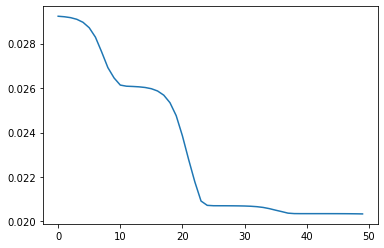

In [18]:
plt.plot(laghist)
plt.show()

Lagrangian for predicted theta:  0.020338822591494825
RND predicted theta vs. true theta:  1.2996558809952756
RND predicted v vs. true v:  106.98976755434016
RND predicted v vs. training v:  0.96382342236858


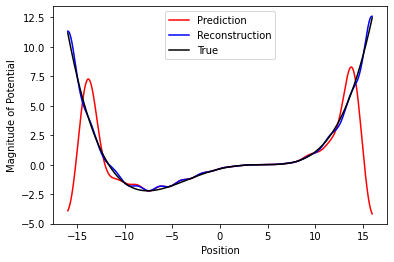

In [20]:
# results

# Print value of Lagrangian for predicted theta
print('Lagrangian for predicted theta: ', justlag(resform))

# Relative norm difference of predicted theta to true theta
print('RND predicted theta vs. true theta: ', nl.norm(resform - cfftrue) / nl.norm(cfftrue))

# use the predicted theta to compute the predicted potential
vformprdc = gmatplot @ resform

# Relative norm difference of the predicted potential to true potential
print('RND predicted v vs. true v: ', nl.norm(vtrue - vformprdc))

# Relative norm difference of the predicted potential to training data
print('RND predicted v vs. training v: ', nl.norm(vtruerecon - vformprdc) / nl.norm(vtruerecon))

# red = learned potential
# blue = reconstructed potential
# black = true potential
trim = 1
plt.plot(xvec[trim:-trim], vformprdc[trim:-trim], color='red', label='Prediction')
plt.plot(xvec[trim:-trim], vtruerecon[trim:-trim], color='blue', label='Reconstruction')
plt.plot(xvec[trim:-trim], vtrue[trim:-trim], color='black', label='True')
plt.xlabel('Position')
plt.ylabel('Magnitude of Potential')
plt.legend()
plt.show()

**Propagate System with Found Coefficents**

Element difference:
 [-0.00015448+0.00502113j  0.00904575+0.00404902j  0.01780947+0.00280006j
 ... -0.01746236+0.00663043j -0.0091857 +0.00584j
 -0.00015448+0.00502113j]
Norm of difference: 1.1453485883162655


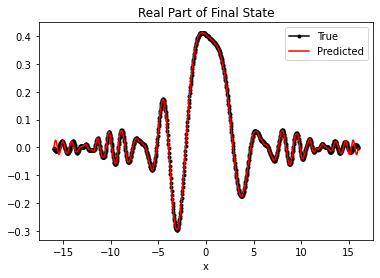

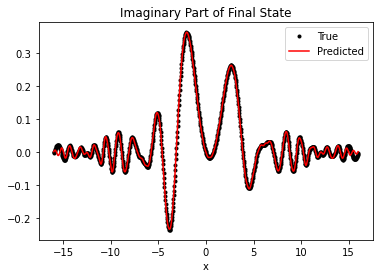

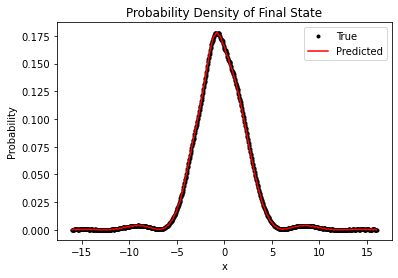

In [30]:
# propagate inita using the predicted coefficents
_, _, amatform, _ = propa(resform.x, inita)
    
# transform amat to real space
psimatform = amatform @ convmat

print('Element difference:\n', psimatform[-1] - psimattrue[-1])
print('Norm of difference:', nl.norm(psimatform - psimattrue))

plt.plot(xvec, psimattrue[-1].real, 'k.-', label='True')
plt.plot(xvec, psimatform[-1].real, 'r', label='Predicted')
plt.legend()
plt.title('Real Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, psimattrue[-1].imag, 'k.', label='True')
plt.plot(xvec, psimatform[-1].imag, 'r', label='Predicted')
plt.legend()
plt.title('Imaginary Part of Final State')
plt.xlabel('x')
plt.show()

plt.plot(xvec, np.abs(psimattrue[-1])**2, 'k.', label='True')
plt.plot(xvec, np.abs(psimatform[-1])**2, 'r', label='Predicted')
plt.legend()
plt.title('Probability Density of Final State')
plt.xlabel('x')
plt.ylabel('Probability')
plt.show()